# Imports and Functions

In [129]:
import pandas as pd
import altair as alt
import numpy as np
import pandas_profiling
import matplotlib.font_manager
import math
from geopy import distance

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Load the Data

In [200]:
df_cb = pd.read_feather("../data/citibike_data_201810-201909.feather")
df_cb.shape

(740460, 15)

In [201]:
df_cb.starttime = pd.to_datetime(df_cb.starttime, format="%Y-%m-%d %H:%M:%S.%f")
df_cb.stoptime = pd.to_datetime(df_cb.stoptime, format="%Y-%m-%d %H:%M:%S.%f")

# Profile the Data

In [31]:
profile = df_cb.profile_report(title="Pandas Profiling Report")
profile.to_file(output_file="../data/citibike_data_report.html")

# Basic Feature Engineering

In [202]:
df_cb["start_year"] = df_cb.starttime.dt.year
df_cb["start_month"] = df_cb.starttime.dt.month
df_cb["start_day"] = df_cb.starttime.dt.day
df_cb["start_year_month"] = df_cb.starttime.values.astype("<M8[M]")

# Sanity Checks

## 1. No one arrives before they leave

In [53]:
(df_cb.starttime > df_cb.stoptime).sum()

0

## 2.The trip duration matches the difference between the starttime and the stoptime

In [203]:
df_cb["calculatedduration"] = (df_cb.stoptime - df_cb.starttime).dt.total_seconds().astype(int)
df_cb.loc[df_cb.calculatedduration != df_cb.tripduration, ["calculatedduration", "tripduration"]]
df_cb["duration_diff"] = df_cb.calculatedduration -  df_cb.tripduration
df_cb.sort_values("duration_diff")

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bikeid,usertype,birth_year,gender,start_year,start_month,start_day,start_year_month,calculatedduration,duration_diff
297679,649056,2017-11-03 09:58:26.000,2017-11-10 21:16:02.000,3273,Manila & 1st,40.721651,-74.042884,3639,Harborside,40.719252,...,31547,Customer,NaN,0,2017,11,3,2017-11-01,645456,-3600
592482,151376,2018-11-03 01:30:12.991,2018-11-04 18:33:09.585,3196,Riverview Park,40.744319,-74.043991,3198,Heights Elevator,40.748716,...,29442,Customer,1999.0,2,2018,11,3,2018-11-01,147776,-3600
488442,1604,2019-08-27 14:28:53.809,2019-08-27 14:55:37.922,3202,Newport PATH,40.727224,-74.033759,3192,Liberty Light Rail,40.711242,...,26291,Customer,1969.0,0,2019,8,27,2019-08-01,1604,0
488443,1587,2019-08-27 14:29:06.542,2019-08-27 14:55:34.116,3202,Newport PATH,40.727224,-74.033759,3192,Liberty Light Rail,40.711242,...,28242,Customer,1969.0,0,2019,8,27,2019-08-01,1587,0
488444,1517,2019-08-27 14:30:31.984,2019-08-27 14:55:49.891,3202,Newport PATH,40.727224,-74.033759,3192,Liberty Light Rail,40.711242,...,29509,Customer,1988.0,2,2019,8,27,2019-08-01,1517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581553,385,2017-12-22 15:27:10.000,2017-12-22 15:33:36.000,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,...,31825,Subscriber,1976.0,1,2017,12,22,2017-12-01,386,1
45172,61,2017-10-08 10:17:43.000,2017-10-08 10:18:45.000,3185,City Hall,40.717733,-74.043845,3186,Grove St PATH,40.719586,...,31772,Subscriber,1957.0,1,2017,10,8,2017-10-01,62,1
666717,7133,2018-03-11 01:45:43.926,2018-03-11 04:44:37.073,3640,Journal Square,40.733670,-74.062500,3183,Exchange Place,40.716247,...,29624,Subscriber,1973.0,1,2018,3,11,2018-03-01,10733,3600
343222,86937,2019-03-09 15:53:28.591,2019-03-10 17:02:26.216,3184,Paulus Hook,40.714145,-74.033552,3638,Washington St,40.724294,...,26163,Customer,1992.0,2,2019,3,9,2019-03-01,90537,3600


Within 1 second is allowable.  Since there are only 5 values which are off by an hour, instead of trying to figure out if the durations of the starttime and stoptime are wrong, I am just going to remove those rows 

In [204]:
print(df_cb.loc[~df_cb.duration_diff.isin([0,1,-1])].shape)
df_cb = df_cb.loc[df_cb.duration_diff.isin([0,1,-1])]

(5, 21)


## 2a. The trip duration

The number of trips longer than 2 hours, split by hour, rounded down

In [175]:
df_tmp = df_cb.loc[df_cb.tripduration>(60*60*1)]
df_tmp["trip_hours"] = df_tmp.apply(lambda x: x.tripduration/(60*60), axis=1).astype(int)

df_tmp.trip_hours.value_counts().sort_index().head(25)

1     5463
2     1130
3      520
4      216
5      132
6       69
7       62
8       62
9       55
10      48
11      50
12      50
13      38
14      43
15      45
16      24
17      34
18      17
19      28
20      22
21      20
22      26
23      22
24      12
25      12
Name: trip_hours, dtype: int64

## 3.Check for birth years outside the expected range

In [98]:
display(df_cb.birth_year.value_counts().sort_index().head(20))
display(df_cb.birth_year.value_counts().sort_index().tail(20))

1887.0     27
1888.0    197
1889.0      4
1900.0     48
1904.0     19
1905.0      1
1918.0      2
1931.0    132
1939.0      3
1940.0     14
1941.0    229
1942.0      9
1943.0      2
1944.0    141
1945.0      4
1946.0     28
1947.0    100
1948.0     23
1949.0    925
1950.0    497
Name: birth_year, dtype: int64

1984.0    30403
1985.0    30043
1986.0    38078
1987.0    37289
1988.0    42883
1989.0    37520
1990.0    32760
1991.0    29150
1992.0    23984
1993.0    19291
1994.0    17669
1995.0     9491
1996.0     5568
1997.0     1865
1998.0     2164
1999.0      628
2000.0      741
2001.0      113
2002.0      118
2003.0       40
Name: birth_year, dtype: int64

Replace any birthdates before 1931 with null values

In [205]:
df_cb.loc[df_cb.birth_year<1931, "birth_year"] = np.NAN

## 4.Check for any unreasonable spikes in birth_year (default values)

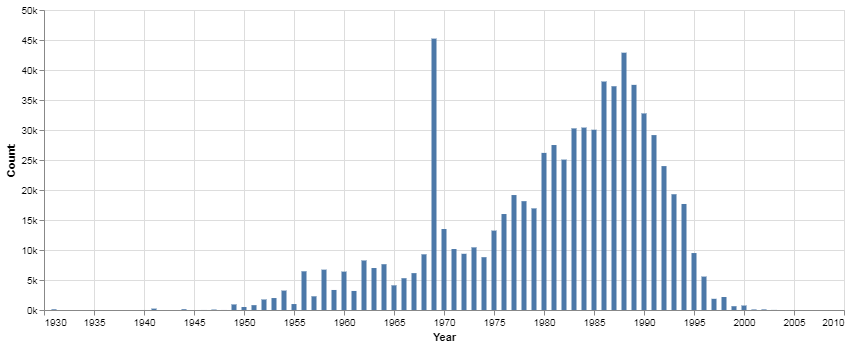

In [108]:
df_tmp = (
    df_cb[["birth_year", "tripduration"]]
    .groupby("birth_year", as_index=False, sort=False)
    .count()
    .rename(columns={"tripduration": "col_count"})
)

alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X("birth_year:Q", title="Year", axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip("birth_year", title="Birth Year")]
).properties(height=300, width=800).interactive()

1969 is probably the default value.  Replace it with null

In [206]:
df_cb.loc[df_cb.birth_year==1969, "birth_year"] = np.NAN

## Rides To/From test locations

In [189]:
df_cb.start_station_name.unique().tolist()

['City Hall',
 'Grand St',
 'Washington St',
 'Hilltop',
 'Harborside',
 'Exchange Place',
 'McGinley Square',
 'Hamilton Park',
 'Oakland Ave',
 'Jersey & 3rd',
 'Grove St PATH',
 'Monmouth and 6th',
 'Dixon Mills',
 'Marin Light Rail',
 'Morris Canal',
 'Glenwood Ave',
 'Brunswick St',
 'Essex Light Rail',
 'Baldwin at Montgomery',
 'Brunswick & 6th',
 'Fairmount Ave',
 'Jersey & 6th St',
 'Newport Pkwy',
 'Jackson Square',
 'Leonard Gordon Park',
 'Van Vorst Park',
 'Pershing Field',
 'Paulus Hook',
 'Warren St',
 'Columbus Drive',
 'Liberty Light Rail',
 'Bergen Ave',
 'Astor Place',
 'Lafayette Park',
 'Sip Ave',
 'Montgomery St',
 'Lincoln Park',
 'JC Medical Center',
 'Communipaw & Berry Lane',
 'Riverview Park',
 'Newport PATH',
 'York St',
 'Christ Hospital',
 'Union St',
 'Journal Square',
 'Manila & 1st',
 '5 Corners Library',
 'Newark Ave',
 'Dey St',
 'Heights Elevator',
 'JCBS Depot',
 'Hoboken Ave at Monmouth St',
 'Bayside Park',
 'Garfield Ave Station',
 'West Side Lig

In [184]:
df_cb.end_station_name.unique().tolist()

['Dixon Mills',
 'Hamilton Park',
 'Harborside',
 'Christ Hospital',
 'Newport PATH',
 'Grand St',
 'Bergen Ave',
 'City Hall',
 'Washington St',
 'Grove St PATH',
 'JC Medical Center',
 'Exchange Place',
 'Sip Ave',
 'Columbus Drive',
 'Paulus Hook',
 'Journal Square',
 'Brunswick & 6th',
 'Brunswick St',
 'Manila & 1st',
 'Essex Light Rail',
 'Jersey & 3rd',
 'McGinley Square',
 'Newport Pkwy',
 'Baldwin at Montgomery',
 'Heights Elevator',
 'Liberty Light Rail',
 'Jersey & 6th St',
 'Warren St',
 'Van Vorst Park',
 'Newark Ave',
 'Hilltop',
 'Jackson Square',
 'Morris Canal',
 'Glenwood Ave',
 'Lincoln Park',
 'Dey St',
 'Monmouth and 6th',
 'York St',
 'Montgomery St',
 'Riverview Park',
 'Marin Light Rail',
 '5 Corners Library',
 'Oakland Ave',
 'Astor Place',
 'Leonard Gordon Park',
 'Fairmount Ave',
 'Pershing Field',
 'Union St',
 'Communipaw & Berry Lane',
 'Lafayette Park',
 'Mercer St & Spring St',
 'JCBS Depot',
 '12 Ave & W 40 St',
 'Vesey Pl & River Terrace',
 'Norfolk St

In [207]:
test_stations = ["JCBS Depot", "WS Don't Use", "Hs Don't Use", "JSQ Don't Use"]
df_cb = df_cb.loc[(~df_cb.start_station_name.isin(test_stations)) & (~df_cb.end_station_name.isin(test_stations))]

# EDA

In [37]:
df_cb.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_year,start_month,start_day,start_year_month
0,311,2019-05-01 00:07:36.467,2019-05-01 00:12:47.635,3185,City Hall,40.717733,-74.043845,3279,Dixon Mills,40.721630,-74.049968,29224,Subscriber,1988.0,1,2019,5,1,2019-05-01
1,538,2019-05-01 00:08:29.284,2019-05-01 00:17:27.941,3681,Grand St,40.715178,-74.037683,3203,Hamilton Park,40.727596,-74.044247,26170,Subscriber,1974.0,1,2019,5,1,2019-05-01
2,178,2019-05-01 00:39:36.475,2019-05-01 00:42:34.964,3638,Washington St,40.724294,-74.035483,3639,Harborside,40.719252,-74.034234,29517,Subscriber,1988.0,1,2019,5,1,2019-05-01
3,317,2019-05-01 01:24:28.022,2019-05-01 01:29:45.573,3206,Hilltop,40.731169,-74.057574,3212,Christ Hospital,40.734786,-74.050444,29606,Subscriber,1986.0,2,2019,5,1,2019-05-01
4,354,2019-05-01 01:54:39.666,2019-05-01 02:00:34.175,3639,Harborside,40.719252,-74.034234,3202,Newport PATH,40.727224,-74.033759,26224,Customer,1986.0,2,2019,5,1,2019-05-01


## Ridership per Month

### Numbers of rides

You would expect the number of riders to peak in the increase in the spring, peak in the summer, decrease in the fall and nadir in the winter.

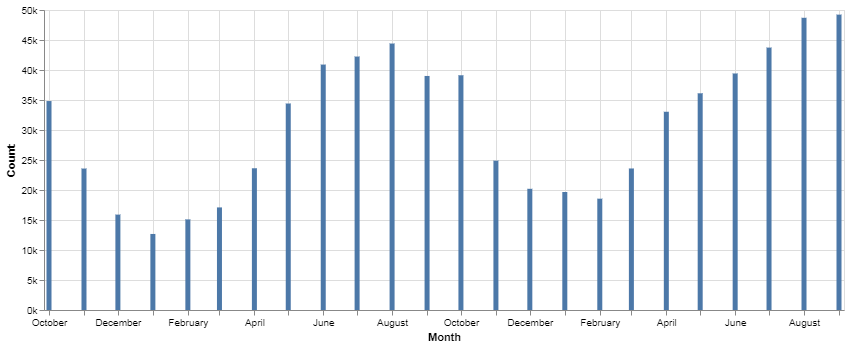

In [209]:
df_tmp = (
    df_cb[["start_year_month", "tripduration"]]
    .groupby("start_year_month", as_index=False, sort=False)
    .count()
    .rename(columns={"tripduration": "col_count"})
)

alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X("start_year_month:T", title="Month"),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[alt.Tooltip("start_year_month", title="Year-Month"),
            alt.Tooltip("col_count", title="Count", format="s")]
).properties(height=300, width=800)

### Median length of ride

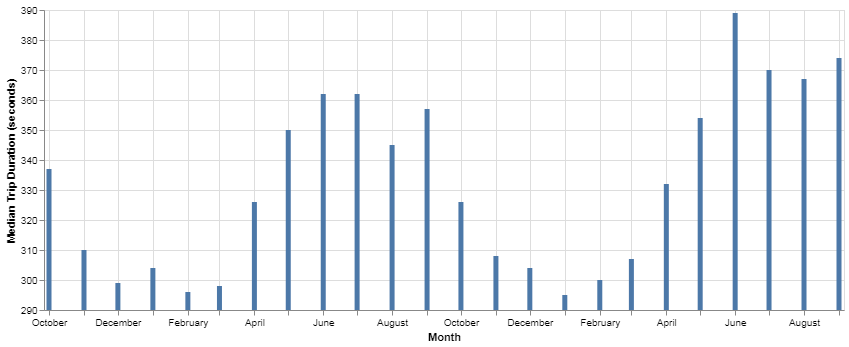

In [210]:
df_tmp = (
    df_cb[["start_year_month", "tripduration"]]
    .groupby("start_year_month", as_index=False, sort=False)
    .median()
    .rename(columns={"tripduration": "median_duration"})
)


alt.Chart(df_tmp).mark_bar().encode(
    x = alt.X("start_year_month:T", title="Month"),
    y = alt.Y("median_duration", title="Median Trip Duration (seconds)", axis=alt.Axis(format="s"), scale=alt.Scale(zero=False)),
    tooltip=[alt.Tooltip("median_duration", title="Median Trip Duration", format="s")]
).properties(height=300, width=800)

## Trip Duration vs Trip Distance

In [211]:
df_cb["start_lat_long"] = list(
    zip(df_cb.start_station_latitude, df_cb.start_station_longitude)
)
df_cb["end_lat_long"] = list(
    zip(df_cb.end_station_latitude, df_cb.end_station_longitude)
)

In [212]:
df_cb["trip_distance"] = df_cb.apply(
    lambda x: distance.distance(x.start_lat_long, x.end_lat_long).miles, axis=1
)

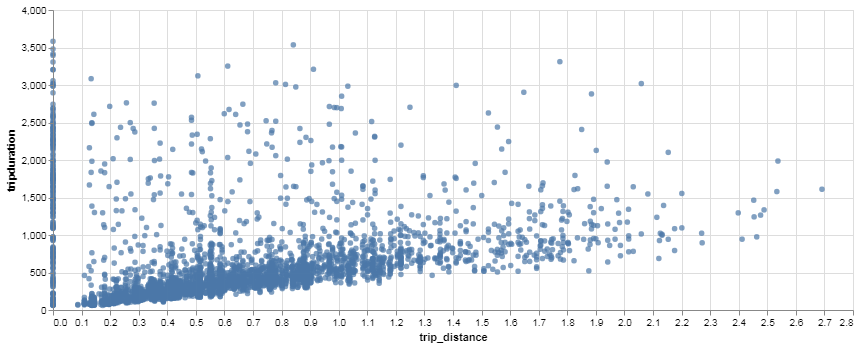

In [223]:
df_tmp = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["trip_distance", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

alt.Chart(df_tmp).mark_circle().encode(
    x=alt.X("trip_distance"),
    y=alt.Y("tripduration"),
    tooltip=[
        alt.Tooltip("tripduration", title="Duration (sec)"),
        alt.Tooltip("trip_distance", title="Distance (miles)"),
    ],
).properties(height=300, width=800)

In [127]:
df_cb.head().T

,0,1,2,3,4
tripduration,311,538,178,317,354
starttime,2019-05-01 00:07:36.467000,2019-05-01 00:08:29.284000,2019-05-01 00:39:36.475000,2019-05-01 01:24:28.022000,2019-05-01 01:54:39.666000
stoptime,2019-05-01 00:12:47.635000,2019-05-01 00:17:27.941000,2019-05-01 00:42:34.964000,2019-05-01 01:29:45.573000,2019-05-01 02:00:34.175000
start_station_id,3185,3681,3638,3206,3639
start_station_name,City Hall,Grand St,Washington St,Hilltop,Harborside
start_station_latitude,40.7177,40.7152,40.7243,40.7312,40.7193
start_station_longitude,-74.0438,-74.0377,-74.0355,-74.0576,-74.0342
end_station_id,3279,3203,3639,3212,3202
end_station_name,Dixon Mills,Hamilton Park,Harborside,Christ Hospital,Newport PATH
end_station_latitude,40.7216,40.7276,40.7193,40.7348,40.7272


In [126]:
df_cb.head().apply(lambda x: distance((x.start_station_latitude, x.start_station_longitude), (x.end_station_latitude, x.end_station_longitude)), axis=1)

0    0.673866
1    1.487531
2    0.570477
3    0.722958
4    0.887327
dtype: float64

In [124]:
df_cb.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bikeid,usertype,birth_year,gender,start_year,start_month,start_day,start_year_month,calculatedduration,duration_diff
0,311,2019-05-01 00:07:36.467,2019-05-01 00:12:47.635,3185,City Hall,40.717733,-74.043845,3279,Dixon Mills,40.721630,...,29224,Subscriber,1988.0,1,2019,5,1,2019-05-01,311,0
1,538,2019-05-01 00:08:29.284,2019-05-01 00:17:27.941,3681,Grand St,40.715178,-74.037683,3203,Hamilton Park,40.727596,...,26170,Subscriber,1974.0,1,2019,5,1,2019-05-01,538,0
2,178,2019-05-01 00:39:36.475,2019-05-01 00:42:34.964,3638,Washington St,40.724294,-74.035483,3639,Harborside,40.719252,...,29517,Subscriber,1988.0,1,2019,5,1,2019-05-01,178,0
3,317,2019-05-01 01:24:28.022,2019-05-01 01:29:45.573,3206,Hilltop,40.731169,-74.057574,3212,Christ Hospital,40.734786,...,29606,Subscriber,1986.0,2,2019,5,1,2019-05-01,317,0
4,354,2019-05-01 01:54:39.666,2019-05-01 02:00:34.175,3639,Harborside,40.719252,-74.034234,3202,Newport PATH,40.727224,...,26224,Customer,1986.0,2,2019,5,1,2019-05-01,354,0


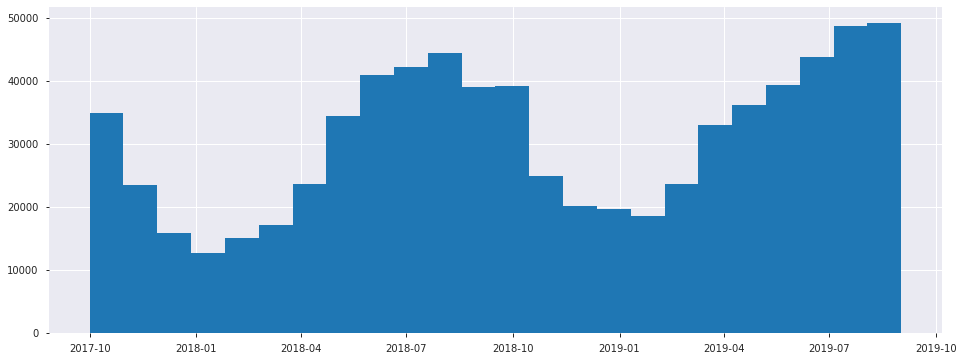

In [33]:
df_cb.start_year_month.hist(figsize=(16,6), bins=24)

In [15]:
df_cb.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [14]:
aa = alt.Chart()

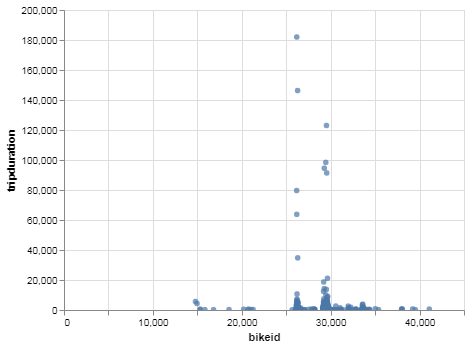

In [19]:
df_tmp = df_cb.sample(5 * 10 ** 3)

alt.Chart(df_tmp).mark_circle().encode(x=alt.X("bikeid"), y=alt.Y("tripduration")).interactive()